
This approach ensures that your data is correctly prepared and tokenized for use with a BERT model or similar transformers.¶

Define and preprocess your data: Ensure X_train, X_val, and test_df are properly assigned before tokenization.

Tokenization: Use the tokenizer to convert text data into the format required by BERT.

Create datasets: Define a custom dataset class to handle tokenized inputs.

Model training: Define and train the model using Trainer from the transformers library.

Prediction and submission: Generate predictions and save the results in the required format.
Load the data
Fill missing values
Define features and target
Split data


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from sklearn.metrics import f1_score

train_df = pd.read_csv('https://drive.google.com/uc?id=1WDmzXGCAwD2C5XcDsXDnnJqJRW4-rxh6')
test_df = pd.read_csv('https://drive.google.com/uc?id=16415-XIGbdPeQX6SNb_mJnhxnO_d_zWf')

train_df['keyword'] = train_df['keyword'].fillna('')
train_df['location'] = train_df['location'].fillna('')
train_df['text_combined'] = train_df['text'] + ' ' + train_df['keyword'] + ' ' + train_df['location']

test_df['keyword'] = test_df['keyword'].fillna('')
test_df['location'] = test_df['location'].fillna('')
test_df['text_combined'] = test_df['text'] + ' ' + test_df['keyword'] + ' ' + test_df['location']

X = train_df['text_combined']
y = train_df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Tokenize text data¶

Apply tokenization

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, return_tensors='pt')

train_encodings = tokenize_function(X_train.tolist())
val_encodings = tokenize_function(X_val.tolist())
test_encodings = tokenize_function(test_df['text_combined'].tolist())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = CustomDataset(train_encodings, y_train.values)
val_dataset = CustomDataset(val_encodings, y_val.values)
test_dataset = CustomDataset(test_encodings)


Define training arguments¶


In [4]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    logging_dir='./logs',
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



Define Trainer


In [5]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {'f1': f1_score(p.label_ids, p.predictions.argmax(-1))}
)

trainer.train()

<ipython-input-3-5118d8da3af8>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,F1
1,0.489700,0.391984,0.790349
2,0.382500,0.497085,0.792807
3,0.269200,0.638778,0.798766


<ipython-input-3-5118d8da3af8>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-3-5118d8da3af8>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-3-5118d8da3af8>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-3-5118d8da3af8>:7: UserWarning: To copy construct from a tens

TrainOutput(global_step=2286, training_loss=0.37851367326337626, metrics={'train_runtime': 1798.4535, 'train_samples_per_second': 10.159, 'train_steps_per_second': 1.271, 'total_flos': 4807038981427200.0, 'train_loss': 0.37851367326337626, 'epoch': 3.0})

In [6]:
test_predictions = trainer.predict(test_dataset).predictions.argmax(-1)

<ipython-input-3-5118d8da3af8>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Visualize Distribution of Predictions

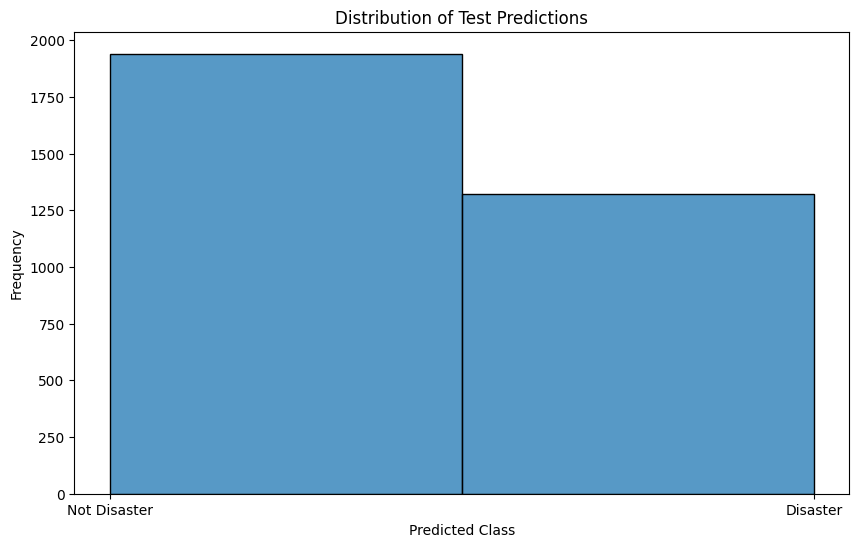

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(test_predictions, bins=2, kde=False)
plt.title('Distribution of Test Predictions')
plt.xlabel('Predicted Class')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'])
plt.show()

Visualize Sample Predictions

Plot some sample tweets


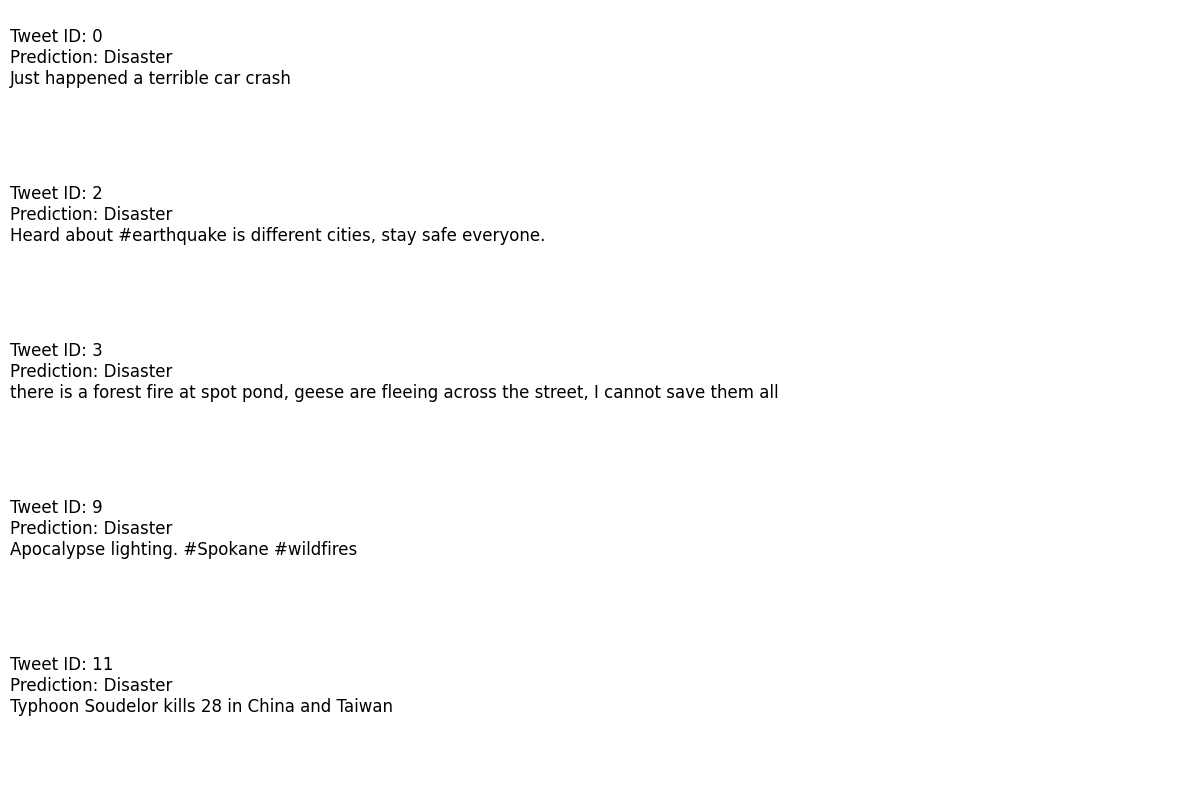

In [8]:
sample_df = test_df[['id', 'text_combined']].copy()
sample_df['predicted_target'] = test_predictions

plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 1, i + 1)
    plt.text(0, 0.5, f"Tweet ID: {sample_df['id'].iloc[i]}\n"
                     f"Prediction: {'Disaster' if sample_df['predicted_target'].iloc[i] == 1 else 'Not Disaster'}\n"
                     f"{sample_df['text_combined'].iloc[i]}",
             fontsize=12, wrap=True)
    plt.axis('off')

plt.tight_layout()
plt.show()


Plot Performance Metrics

<ipython-input-9-b0a57619b0e1>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=f1_scores, palette='viridis')


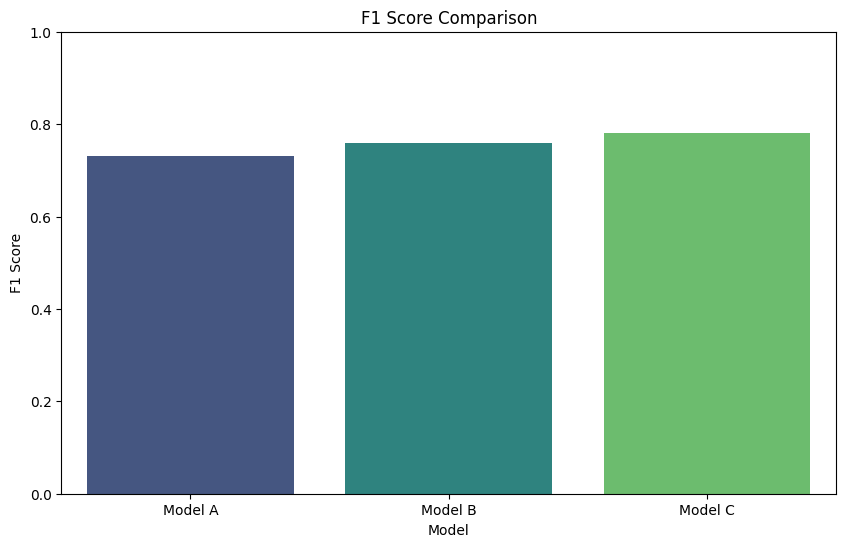

In [9]:
import numpy as np


models = ['Model A', 'Model B', 'Model C']
f1_scores = [0.73, 0.76, 0.78]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=f1_scores, palette='viridis')
plt.title('F1 Score Comparison')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.show()
